In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics  
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns
import pandas as pd
import math
from astropy.table import Table
import astropy.units as u
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, RocCurveDisplay, precision_recall_curve, f1_score


In [21]:
t = Table.read('gll_psc_v16.fit')

# remove features that are not useful or contain uncertainties
good_features  = [
    "Signif_Avg", "Flux_Density", 
    "Flux1000", "Energy_Flux100", "Signif_Curve", 
    "Spectral_Index", "beta", "PowerLaw_Index", 
    "Variability_Index", "Flux_Peak", "Peak_Interval", 
    "Flux100_300", "Flux300_1000", "Flux1000_3000",
    "Flux3000_10000", "Flux10000_100000", "CLASS1"
]

filtered_table = t[good_features]

# only look at bll, fsrq and bcu blazars
filtered_blazarTable = filtered_table[[cls in ['bll  ', 'BLL  ', 'fsrq ','FSRQ ', 'bcu  ','BCU  '] for cls in t['CLASS1']]]

# calculate hardness ratio for bins: https://arxiv.org/pdf/1306.6529
    # Flux100_300
    # Flux300_1000
    # Flux1000_3000
    # Flux3000_10000
    # Flux10000_100000


# HR = (EFj - EFi)/(EFj + EFi)
# HR100_300_1000
E1i = math.log(100) + (math.log(300)-math.log(100))/2
E1j = math.log(300) + (math.log(1000)-math.log(300))/2

# HR300_1000_3000
E2i = E1j
E2j = math.log(1000) + (math.log(3000)-math.log(1000))/2

# HR1000_3000_10000
E3i = E2j
E3j = math.log(3000) + (math.log(10000)-math.log(3000))/2

# HR3000_10000_100000
E4i = E3j
E4j = math.log(10000) + (math.log(100000)-math.log(10000))/2


filtered_blazarTable['HR1'] = (E1i*np.log(filtered_blazarTable['Flux100_300']) - E1j*np.log(filtered_blazarTable['Flux300_1000']))/(E1i*np.log(filtered_blazarTable['Flux100_300']) + E1j*np.log(filtered_blazarTable['Flux300_1000']))
filtered_blazarTable['HR2'] = (E2i*np.log(filtered_blazarTable['Flux300_1000']) - E2j*np.log(filtered_blazarTable['Flux1000_3000']))/(E2i*np.log(filtered_blazarTable['Flux300_1000']) + E2j*np.log(filtered_blazarTable['Flux1000_3000']))
filtered_blazarTable['HR3'] = (E3i*np.log(filtered_blazarTable['Flux1000_3000']) - E3j*np.log(filtered_blazarTable['Flux3000_10000']))/(E3i*np.log(filtered_blazarTable['Flux1000_3000']) + E3j*np.log(filtered_blazarTable['Flux3000_10000']))
filtered_blazarTable['HR4'] = (E4i*np.log(filtered_blazarTable['Flux3000_10000']) - E4j*np.log(filtered_blazarTable['Flux10000_100000']))/(E4i*np.log(filtered_blazarTable['Flux3000_10000']) + E4j*np.log(filtered_blazarTable['Flux10000_100000']))

filtered_blazarTable['HS1'] = filtered_blazarTable['HR1'] - filtered_blazarTable['HR2']
filtered_blazarTable['HS2'] = filtered_blazarTable['HR2'] - filtered_blazarTable['HR3']
filtered_blazarTable['HS3'] = filtered_blazarTable['HR3'] - filtered_blazarTable['HR4']

# now can remove the flux100_300 ... etc 
fluxes = [
    'Flux100_300',
    'Flux300_1000',
    'Flux1000_3000',
    'Flux3000_10000',
    'Flux10000_100000'
]

all_columns_in_filtered = filtered_blazarTable.colnames  # This returns a list of all column names in the table

# Step 2: Find the remaining columns after removal
no_flux = [col for col in all_columns_in_filtered if col not in fluxes]

# doesn't include features that can be immediatly removed like name 
filtered_blazarTable = filtered_blazarTable[no_flux]

# normalising Flux peak
filtered_blazarTable['Normalised_Flux_Peak'] = filtered_blazarTable['Flux_Peak']/filtered_blazarTable['Energy_Flux100']
filtered_blazarTable['loggedFlux_Density'] = np.log(filtered_blazarTable['Flux_Density'])

for col in filtered_blazarTable.colnames:
    filtered_blazarTable[col][filtered_blazarTable[col] == -np.inf] = np.nan

# RF ready table, only BLL and FSRQ
mask = [(cls in ['bll  ', 'BLL  ', 'fsrq ', 'FSRQ ']) for cls in filtered_blazarTable['CLASS1']]
RF_ready_filtered_blazarTable = filtered_blazarTable[mask]
# make it so that bll or BLL are just BLL, fsrq or FSRQ are FSRQ

RF_ready_filtered_blazarTable['CLASS1'] = ['BLL' if cls in ['bll  ', 'BLL  '] else 'FSRQ' if cls in [ 'fsrq ', 'FSRQ '] else cls for cls in RF_ready_filtered_blazarTable['CLASS1']]

# keep the good features, remove the highly correlated features
# removing Signif_Avg, Energy_Flux100, Flux1000, spectral_Index

# after the correlation matrix, these features are uncorrelated:
pre_feature_selection_good_features = [
    "loggedFlux_Density",
    "Flux1000",
    "Signif_Curve",
    "PowerLaw_Index",
    "Variability_Index",
    "Normalised_Flux_Peak",
    "Peak_Interval",
    "beta",
    "HR1",
    "HR3",
    "HR4"
]

# FULLY FILTERED FEATURES
X_fully_filtered = RF_ready_filtered_blazarTable[pre_feature_selection_good_features].to_pandas()
y_fully_filtered = RF_ready_filtered_blazarTable['CLASS1'].data


seven_features = ['HR1', 'Variability_Index', 'HR4', 'HR3', 'loggedFlux_Density', 'Normalised_Flux_Peak', 'PowerLaw_Index']

X_seven_feature = X_fully_filtered[seven_features]
y_seven_feature = y_fully_filtered


In [52]:
# Use entire 3fgl set and do cross validation to find the precision and recall scores, find the threshold for .90 precision and use that for the 4fgl classifications. After that, then try a new threshold for a different precision just to compare. (1) 
# graphing precision and recall and f-score
def plot_precision_recall_fscore(X_train, y_train, positive_class_label, title_prefix):
    X_array = np.array(X_train)  
    y_array = np.array(y_train)

    precisions, recalls = [], []
    label_mapping = {'FSRQ': 0, 'BLL': 1} if positive_class_label == 'BLL' else {'FSRQ': 1, 'BLL': 0}

    y_array_numeric = np.array([label_mapping[label] for label in y_array])

    mean_thresholds = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    
    # Set up the cross-validation
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    rf_final = RandomForestClassifier(bootstrap=True, ccp_alpha=0, max_features='sqrt', min_samples_leaf=8, min_samples_split=3, n_estimators=150, random_state=42)
    
    # Loop through each fold
    for i, (train, test) in enumerate(kf.split(X_array, y_array_numeric)):
        # Fit the model on the training data
        rf_final.fit(X_array[train], y_array_numeric[train])



        y_proba = rf_final.predict_proba(X_array[test])[:,1] #1 for the positive class
        precision, recall, thresholds = precision_recall_curve(y_array_numeric[test], y_proba, pos_label=1)
        # remove last element from precision and recall
        precision = precision[:-1]
        recall = recall[:-1]
    
        # calculate f1-score for threshold > t
        f1_scores = []

        max_f1_score = 0
        max_at_threshold = -10;
        threshold_for_precision_90 = None
        threshold_for_precision_80 = None
        for i, threshold in enumerate(thresholds):
            # Convert probabilities to binary predictions based on threshold
            y_pred = (y_proba >= threshold).astype(int)
            
            # Calculate F1 score
            f1 = f1_score(y_array_numeric[test], y_pred, pos_label=1)
            f1_scores.append(f1)
            if f1 > max_f1_score:
                max_f1_score = f1
                max_at_threshold = threshold
            if precision[i] > 0.90 and threshold_for_precision_90 is None:
                threshold_for_precision_90 = threshold
            if precision[i] > 0.80 and threshold_for_precision_80 is None:
                threshold_for_precision_80 = threshold

        ax.plot(thresholds, precision, lw=1, alpha=0.3, color="darkorange")
        ax.plot(thresholds, recall, lw=1, alpha=0.3, color="blue")
        ax.plot(thresholds, f1_scores, lw=1, alpha=0.3, color="green")

    
    # find average by looking at the full set of the cross_val_results
    cross_val_results = cross_val_predict(rf_final, X_array, y_array_numeric, cv=kf, method='predict_proba')  
    CV_f1_scores = []

    CV_precision, CV_recall, CV_thresholds = precision_recall_curve(y_array_numeric, cross_val_results[:,1], pos_label=1)
    for t in CV_thresholds:
        f1 = f1_score(y_array_numeric, (cross_val_results[:,1] > t).astype(int), pos_label=1)
        CV_f1_scores.append(f1)

    plt.axhline(y=0.90, color='r', linestyle='--', label='threshold for precision at 0.90')
    ax.plot(CV_thresholds, CV_precision[:-1], lw=1, alpha=1, color="darkorange", label='Precision')
    ax.plot(CV_thresholds, CV_recall[:-1], lw=1, alpha=1, color="darkblue", label='Recall')
    ax.plot(CV_thresholds, CV_f1_scores, lw=1, alpha=1, color="green", label='F1-score')
    
    
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    ax.grid(True)
    
    # Set labels and titles
    ax.set(xlabel="Threshold", ylabel="Score", title=f"{title_prefix}: Precision and Recall vs. Threshold")
    
    print(f'max_f1_score: {max_f1_score}, with threshold = {max_at_threshold}')
    print(f'{positive_class_label} threshold_for_precision_90: {threshold_for_precision_90}')
    print(f'{positive_class_label} threshold_for_precision_80: {threshold_for_precision_80}')

max_f1_score: 0.9003690036900369, with threshold = 0.5221547889248987
BLL threshold_for_precision_90: 0.5221547889248987
BLL threshold_for_precision_80: 0.21054186454228177
max_f1_score: 0.8540540540540541, with threshold = 0.5124030885754736
FSRQ threshold_for_precision_90: 0.70631619539731
FSRQ threshold_for_precision_80: 0.4542463691146252


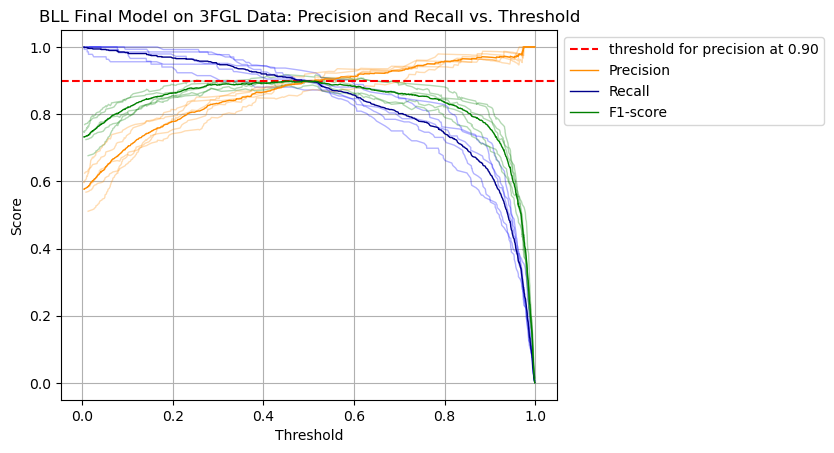

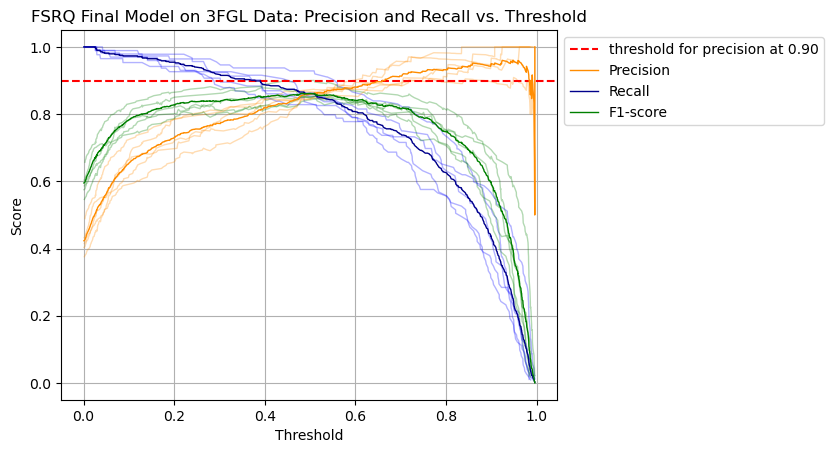

In [53]:
plot_precision_recall_fscore(X_seven_feature, y_seven_feature, positive_class_label='BLL', title_prefix='BLL Final Model on 3FGL Data')
plot_precision_recall_fscore(X_seven_feature, y_seven_feature, positive_class_label='FSRQ', title_prefix='FSRQ Final Model on 3FGL Data')

In [54]:
# Plotting Training Data Score Distributions on the final rf model for FSRQ and BLL
rf_final = RandomForestClassifier(bootstrap=True, ccp_alpha=0, max_features='sqrt', min_samples_leaf=8, min_samples_split=4, n_estimators=150, random_state=42)
# Fit the model on the 3FGL data
rf_final.fit(X_seven_feature, y_seven_feature)


RandomForestClassifier(ccp_alpha=0, min_samples_leaf=8, min_samples_split=4,
                       n_estimators=150, random_state=42)

In [55]:
# Read 3FGL table to find BCUs
t3 = Table.read('gll_psc_v16.fit')
blazarTable3= t3[[cls in ['bll  ', 'BLL  ', 'fsrq ','FSRQ ', 'bcu  ','BCU  '] for cls in t3['CLASS1']]]

In [56]:
# Read 4FGL table
t4 = Table.read('gll_psc_v35.fit')
# only look at bll, fsrq and bcu blazars
blazarTable4= t4[[cls in ['bll  ', 'BLL  ', 'fsrq ','FSRQ ', 'bcu  ','BCU  '] for cls in t4['CLASS1']]]
blazarTable4['CLASS1'] = ['BLL' if cls in ['bll  ', 'BLL  '] else 'FSRQ' if cls in [ 'fsrq ', 'FSRQ '] else cls for cls in blazarTable4['CLASS1']]


In [57]:
# find 3FGL BCUs that are classified in 4FGL
classified_in_4FGL = []
y_classified_in_4FGL = []
changeCount = 0

columns_to_keep3 = ['Source_Name', 'CLASS1']
columns_to_keep4 = ['Source_Name', 'CLASS1', 'ASSOC_FGL']

# Filter tables to keep only the specified columns
filtered_table3 = blazarTable3[columns_to_keep3]
filtered_table4 = blazarTable4[columns_to_keep4]

# Convert to pandas DataFrame
df3 = filtered_table3.to_pandas()
df4 = filtered_table4.to_pandas()

# convert the values to remove white space and make everything uppercase so that it is easy to compare between the two dataframes
df3['CLASS1'] = df3['CLASS1'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
df4['CLASS1'] = df4['CLASS1'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
df4['Source_Name'] = df4['Source_Name'].apply(lambda x: x.decode('utf-8').strip().upper() if isinstance(x, bytes) else x.strip().upper())
df4['ASSOC_FGL'] = df4['ASSOC_FGL'].apply(lambda x: x.decode('utf-8').strip().upper() if isinstance(x, bytes) else x.strip().upper())
df3['Source_Name'] = df3['Source_Name'].apply(lambda x: x.decode('utf-8').strip().upper() if isinstance(x, bytes) else x.strip().upper())


for index, row in df3.iterrows():
    name3 = row['Source_Name']
    class3 = row['CLASS1'].strip().upper()# Strip any extra whitespace
    # check if it is a BCU
    if class3 == 'BCU':
        # check if instance is in 4FGL
        if name3 in df4['ASSOC_FGL'].values:
            # select the row that does have this value
            selected_row = df4[df4['ASSOC_FGL'] == name3].iloc[0]
            # find its class
            class4 = selected_row['CLASS1'].strip().upper()
            if class4 == 'BLL' or class4 == 'FSRQ':
                # keep the original associated catalogue number
                classified_in_4FGL.append(selected_row['ASSOC_FGL'])
                y_classified_in_4FGL.append(class4)
                changeCount += 1;
                
# print(y_classified_in_4FGL)
# print(f'total change count = {changeCount}')

classified_set = set(classified_in_4FGL)

BCU_classified_in_3FGL = blazarTable3[np.isin(np.char.upper(np.char.strip(blazarTable3['Source_Name'])), list(classified_set))]
BCU_associated_in_4FGL = blazarTable4[np.isin(np.char.upper(np.char.strip(blazarTable4['ASSOC_FGL'])), list(classified_set))]
y_associated_in_4FGL = BCU_associated_in_4FGL['CLASS1']

y_associated_in_4FGL

# BCU_classified_in_3FGL


BLL
BLL
FSRQ
FSRQ
BLL
FSRQ
BLL
BLL
BLL
BLL
BLL


In [58]:
# with 3FGL BCU, create the new features, and use only 14 features and classify them

# remove features that are not useful or contain uncertainties
good_features  = [
    "Signif_Avg", "Flux_Density", 
    "Flux1000", "Energy_Flux100", "Signif_Curve", 
    "Spectral_Index", "beta", "PowerLaw_Index", 
    "Variability_Index", "Flux_Peak", "Peak_Interval", 
    "Flux100_300", "Flux300_1000", "Flux1000_3000",
    "Flux3000_10000", "Flux10000_100000", "CLASS1"
]

filtered_BCU_classified_in_3FGL = BCU_classified_in_3FGL[good_features]

# calculate hardness ratio for bins: https://arxiv.org/pdf/1306.6529
    # Flux100_300
    # Flux300_1000
    # Flux1000_3000
    # Flux3000_10000
    # Flux10000_100000


# HR = (EFj - EFi)/(EFj + EFi)
# HR100_300_1000
E1i = math.log(100) + (math.log(300)-math.log(100))/2
E1j = math.log(300) + (math.log(1000)-math.log(300))/2

# HR300_1000_3000
E2i = E1j
E2j = math.log(1000) + (math.log(3000)-math.log(1000))/2

# HR1000_3000_10000
E3i = E2j
E3j = math.log(3000) + (math.log(10000)-math.log(3000))/2

# HR3000_10000_100000
E4i = E3j
E4j = math.log(10000) + (math.log(100000)-math.log(10000))/2


filtered_BCU_classified_in_3FGL['HR1'] = (E1i*np.log(filtered_BCU_classified_in_3FGL['Flux100_300']) - E1j*np.log(filtered_BCU_classified_in_3FGL['Flux300_1000']))/(E1i*np.log(filtered_BCU_classified_in_3FGL['Flux100_300']) + E1j*np.log(filtered_BCU_classified_in_3FGL['Flux300_1000']))
filtered_BCU_classified_in_3FGL['HR2'] = (E2i*np.log(filtered_BCU_classified_in_3FGL['Flux300_1000']) - E2j*np.log(filtered_BCU_classified_in_3FGL['Flux1000_3000']))/(E2i*np.log(filtered_BCU_classified_in_3FGL['Flux300_1000']) + E2j*np.log(filtered_BCU_classified_in_3FGL['Flux1000_3000']))
filtered_BCU_classified_in_3FGL['HR3'] = (E3i*np.log(filtered_BCU_classified_in_3FGL['Flux1000_3000']) - E3j*np.log(filtered_BCU_classified_in_3FGL['Flux3000_10000']))/(E3i*np.log(filtered_BCU_classified_in_3FGL['Flux1000_3000']) + E3j*np.log(filtered_BCU_classified_in_3FGL['Flux3000_10000']))
filtered_BCU_classified_in_3FGL['HR4'] = (E4i*np.log(filtered_BCU_classified_in_3FGL['Flux3000_10000']) - E4j*np.log(filtered_BCU_classified_in_3FGL['Flux10000_100000']))/(E4i*np.log(filtered_BCU_classified_in_3FGL['Flux3000_10000']) + E4j*np.log(filtered_BCU_classified_in_3FGL['Flux10000_100000']))

filtered_BCU_classified_in_3FGL['HS1'] = filtered_BCU_classified_in_3FGL['HR1'] - filtered_BCU_classified_in_3FGL['HR2']
filtered_BCU_classified_in_3FGL['HS2'] = filtered_BCU_classified_in_3FGL['HR2'] - filtered_BCU_classified_in_3FGL['HR3']
filtered_BCU_classified_in_3FGL['HS3'] = filtered_BCU_classified_in_3FGL['HR3'] - filtered_BCU_classified_in_3FGL['HR4']

# now can remove the flux100_300 ... etc 
fluxes = [
    'Flux100_300',
    'Flux300_1000',
    'Flux1000_3000',
    'Flux3000_10000',
    'Flux10000_100000'
]

all_columns_in_filtered = filtered_BCU_classified_in_3FGL.colnames  # This returns a list of all column names in the table

# Step 2: Find the remaining columns after removal
no_flux = [col for col in all_columns_in_filtered if col not in fluxes]

# doesn't include features that can be immediatly removed like name 
filtered_BCU_classified_in_3FGL = filtered_BCU_classified_in_3FGL[no_flux]

# normalising Flux peak
filtered_BCU_classified_in_3FGL['Normalised_Flux_Peak'] = filtered_BCU_classified_in_3FGL['Flux_Peak']/filtered_BCU_classified_in_3FGL['Energy_Flux100']
filtered_BCU_classified_in_3FGL['loggedFlux_Density'] = np.log(filtered_BCU_classified_in_3FGL['Flux_Density'])

for col in filtered_BCU_classified_in_3FGL.colnames:
    filtered_BCU_classified_in_3FGL[col][filtered_BCU_classified_in_3FGL[col] == -np.inf] = np.nan

# keep the good features, remove the highly correlated features
# removing Signif_Avg, Energy_Flux100, Flux1000, spectral_Index

# after the correlation matrix, these features are uncorrelated:
pre_feature_selection_good_features = [
    "Flux_Density",
    "loggedFlux_Density",
    "Signif_Curve",
    "beta",
    "PowerLaw_Index",
    "Variability_Index",
    "Normalised_Flux_Peak",
    "Peak_Interval",
    "HR1",
    "HR2",
    "HR3",
    "HR4",
    "HS1",
    "HS2",
    "HS3"
    
]

# FULLY FILTERED FEATURES
X_3FGL_BCU = filtered_BCU_classified_in_3FGL[pre_feature_selection_good_features].to_pandas()


seven_features = ['HR1', 'Variability_Index', 'HR4', 'HR3', 'loggedFlux_Density', 'Normalised_Flux_Peak', 'PowerLaw_Index']

X_3FGL_BCU_seven_feature = X_3FGL_BCU[seven_features]
y_4FGL_classified_seven_feature = y_associated_in_4FGL


In [59]:
def plot_testing_roc_auc(X_train, y_train, X_test, y_test, positive_class_label, title_prefix):
    X_train_array = np.array(X_train)
    y_train_array = np.array(y_train)
    X_test_array = np.array(X_test)
    y_test_array = np.array(y_test)
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    
    # Set up the cross-validation
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    
    rf_final = RandomForestClassifier(bootstrap=True, ccp_alpha=0, max_features='sqrt', min_samples_leaf=8, min_samples_split=3, n_estimators=150, random_state=42)
    # Fit the model on the training data
    rf_final.fit(X_train_array, y_train_array)
    
    # Loop through each fold
    for i, (train, test) in enumerate(kf.split(X_test_array, y_test_array)):

        # Predict the probabilities on the test data
        if positive_class_label == 'BLL':
            y_proba = rf_final.predict_proba(X_test_array[test])[:,0] #0 for the positive class being BLL
            fpr, tpr, _ = roc_curve(y_test_array[test], y_proba, pos_label='BLL') # Calculate the ROC
        elif positive_class_label == 'FSRQ':
            y_proba = rf_final.predict_proba(X_test_array[test])[:,1] #1 for the positive class being FSRQ
            fpr, tpr, _ = roc_curve(y_test_array[test], y_proba, pos_label='FSRQ') # Calculate the ROC

        roc_auc = auc(fpr, tpr) # Calculate the AUC
        
        # Interpolate the TPR for a common mean FPR
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0 # making sure that the first value is 0 so that the curve starts at 0 (0% false positive rate and 0% true positive rate)
        tprs.append(interp_tpr)
        aucs.append(roc_auc)
        
        # Plot the ROC curve for the current fold
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {roc_auc:.2f})')
    
    # Plot the mean ROC curve across all folds
    mean_tpr = np.mean(tprs, axis=0) # find the mean tpr
    mean_tpr[-1] = 1.0 # making sure that the last value of mean_tpr = 1
    mean_auc = auc(mean_fpr, mean_tpr) # find the mean AUC
    std_auc = np.std(aucs) # find standard deviation in the AUC
    
    ax.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=0.8, label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )
    
    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
    )
    
    # Final plot settings
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=f"{title_prefix}:Receiver Operating Characteristic with Cross-Validation")
    ax.legend(loc="lower right")


In [60]:
# WE ARE NOT LOOKING AT DIFFERENT THRESHOLDS, DON'T USE THIS
# plot_testing_roc_auc(X_seven_feature, y_seven_feature, X_3FGL_BCU_seven_feature, y_associated_in_4FGL, positive_class_label='BLL', title_prefix='BLL ROC and AUC on 3FGL BCU compared to 4FGL Associations')
# plot_testing_roc_auc(X_seven_feature, y_seven_feature, X_3FGL_BCU_seven_feature, y_associated_in_4FGL, positive_class_label='FSRQ', title_prefix='FSRQ ROC and AUC on 3FGL BCU compared to 4FGL Associations')

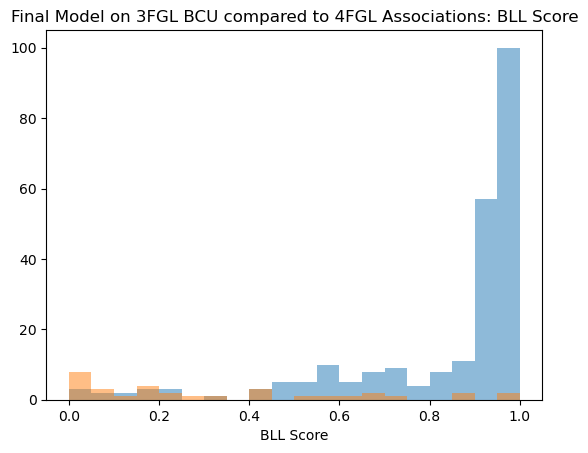

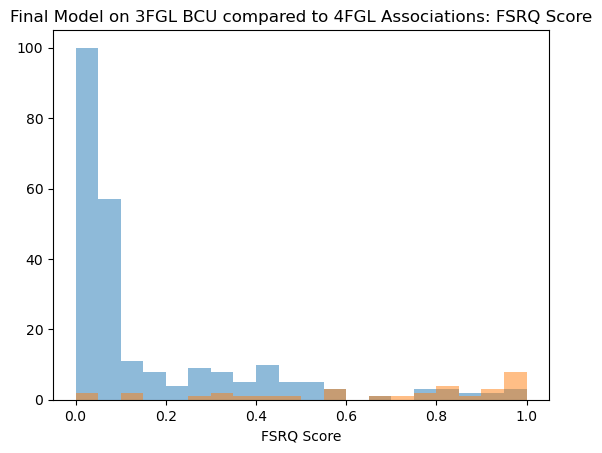

In [61]:
# Plotting Training Data Score Distributions on the final rf model for FSRQ and BLL
rf_final = RandomForestClassifier(bootstrap=True, ccp_alpha=0, max_features='sqrt', min_samples_leaf=8, min_samples_split=3, n_estimators=150, random_state=42)
# Fit the model on the training data
rf_final.fit(X_seven_feature, y_seven_feature)
    
# performing predictions on the test dataset
y_pred = rf_final.predict_proba(X_3FGL_BCU_seven_feature)

plt.hist(y_pred[y_4FGL_classified_seven_feature=='BLL'][:,0], range= (0,1), bins=20, alpha=0.5) 
plt.hist(y_pred[y_4FGL_classified_seven_feature=='FSRQ'][:,0], range= (0,1), bins=20, alpha=0.5)  
plt.xlabel("BLL Score")
plt.title("Final Model on 3FGL BCU compared to 4FGL Associations: BLL Score")
plt.show()

plt.hist(y_pred[y_4FGL_classified_seven_feature=='BLL'][:,1], range= (0,1), bins=20, alpha=0.5) 
plt.hist(y_pred[y_4FGL_classified_seven_feature=='FSRQ'][:,1], range= (0,1), bins=20, alpha=0.5)  
plt.title("Final Model on 3FGL BCU compared to 4FGL Associations: FSRQ Score")
plt.xlabel("FSRQ Score")
plt.show()


In [62]:
# def accuracy_score_with_threshold(X_train, y_train, X_test, y_test, threshold, positive_class_label, title_prefix):
#     X_train_array = np.array(X_train)
#     y_train_array = np.array(y_train)
#     X_test_array = np.array(X_test)
#     y_test_array = np.array(y_test)

#     # creating a RF classifier
#     rf_final = RandomForestClassifier(bootstrap=True, ccp_alpha=0, max_features='sqrt', min_samples_leaf=8, min_samples_split=3, n_estimators=150, random_state=42)
    
#     label_mapping = {'FSRQ': 0, 'BLL': 1} if positive_class_label == 'BLL' else {'FSRQ': 1, 'BLL': 0}
#     y_train_array_numeric = np.array([label_mapping[label] for label in y_train_array])
#     y_test_array_numeric = np.array([label_mapping[label] for label in y_test_array])
        
#     # Training the model on the training dataset
#     # fit function is used to train the model using the training sets as parameters
#     rf_final.fit(X_train_array, y_train_array_numeric)
    
#     # Perform predictions using predict_proba to get the probabilities
#     y_proba = rf_final.predict_proba(X_test_array)[:, 1]  

#     # Apply a threshold 
#     y_pred_thresholded = (y_proba >= threshold).astype(int)
#     # Calculate accuracy with the thresholded predictions
#     accuracy = accuracy_score(y_test_array_numeric, y_pred_thresholded)
#     print(f"{title_prefix} accuracy with threshold >= {threshold}:", accuracy)

In [63]:
# accuracy_score_with_threshold(X_seven_feature, y_seven_feature, X_3FGL_BCU_seven_feature, y_associated_in_4FGL, threshold=0.53, positive_class_label='BLL', title_prefix='BLL: 3FGL BCU compared to 4FGL Associations')
# accuracy_score_with_threshold(X_seven_feature, y_seven_feature, X_3FGL_BCU_seven_feature, y_associated_in_4FGL, threshold=0.53, positive_class_label='FSRQ', title_prefix='FSRQ: 3FGL BCU compared to 4FGL Associations')


# accuracy_score_with_threshold(X_seven_feature, y_seven_feature, X_3FGL_BCU_seven_feature, y_associated_in_4FGL, threshold=0.43, positive_class_label='BLL', title_prefix='BLL: 3FGL BCU compared to 4FGL Associations')
# accuracy_score_with_threshold(X_seven_feature, y_seven_feature, X_3FGL_BCU_seven_feature, y_associated_in_4FGL, threshold=0.43, positive_class_label='FSRQ', title_prefix='FSRQ: 3FGL BCU compared to 4FGL Associations')


In [64]:
# # creating a RF classifier
# rf_final = RandomForestClassifier(bootstrap=True, ccp_alpha=0, max_features='sqrt', min_samples_leaf=8, min_samples_split=3, n_estimators=150, random_state=42)
     
# # Training the model on the training dataset
# # fit function is used to train the model using the training sets as parameters
# rf_final.fit(X_seven_feature, y_seven_feature)
 
# # performing predictions on the test dataset
# y_pred = rf_final.predict(X_3FGL_BCU_seven_feature)
 

# accuracy = accuracy_score(y_associated_in_4FGL, y_pred)
# print("Accuracy:", accuracy)

In [74]:
def accuracy_score_with_BLL_and_FSRQ_threshold(X_train, y_train, X_test, y_test, threshold, positive_class_label, title_prefix):
    X_train_array = np.array(X_train)
    y_train_array = np.array(y_train)
    X_test_array = np.array(X_test)
    y_test_array = np.array(y_test)

    # creating a RF classifier
    rf_final = RandomForestClassifier(bootstrap=True, ccp_alpha=0, max_features='sqrt', min_samples_leaf=8, min_samples_split=3, n_estimators=150, random_state=42)
    
    label_mapping = {'FSRQ': 0, 'BLL': 1} if positive_class_label == 'BLL' else {'FSRQ': 1, 'BLL': 0}
    y_train_array_numeric = np.array([label_mapping[label] for label in y_train_array])
    y_test_array_numeric = np.array([label_mapping[label] for label in y_test_array])
        
    # Training the model on the training dataset
    # fit function is used to train the model using the training sets as parameters
    rf_final.fit(X_train_array, y_train_array_numeric)
    
    # Perform predictions using predict_proba to get the probabilities
    y_proba = rf_final.predict_proba(X_test_array)[:, 1] 

    # Apply threshold
    y_pred_thresholded = (y_proba >= threshold).astype(int)

    
    # Filter only the points where the predicted label is 1 (positive class)
    mask_positive_class = y_pred_thresholded == 1
    y_test_positive = y_test_array_numeric[mask_positive_class]
    y_pred_positive = y_pred_thresholded[mask_positive_class]
    num_predicted_positive_class = len(y_pred_positive)

    # find the number of true positives
    mask_true_positive_class = y_test_array_numeric == 1
    y_test_true_positive = y_test_array_numeric[mask_true_positive_class]
    num_of_class_type = len(y_test_true_positive)

    # find number of wrong predictions
    mask_wrong_predictions = y_test_positive == 0
    num_predicted_wrong_class = len(y_pred_positive[mask_wrong_predictions])
    
    # Calculate accuracy only for the points labeled as 1
    accuracy = accuracy_score(y_test_positive, y_pred_positive)

    # Find the number of correctly classified BCUs
    correctWithinThreshold = (num_predicted_positive_class - num_predicted_wrong_class)

    print(f"{title_prefix} {positive_class_label} accuracy with threshold >= {threshold}:", accuracy)
    print(f"Found {num_predicted_positive_class} predicted positvies of {positive_class_label}. There were originally {num_of_class_type} true positive values of {positive_class_label}. Made {num_predicted_wrong_class} wrong predictions in the threshold of {num_predicted_positive_class} values. Correctly classified {correctWithinThreshold}")



    return correctWithinThreshold, num_predicted_positive_class, num_of_class_type


In [78]:
BLL_correctWithinThreshold, BLL_num_predicted_positive_class, BLL_num_of_class_type = accuracy_score_with_BLL_and_FSRQ_threshold(X_seven_feature, y_seven_feature, X_3FGL_BCU_seven_feature, y_associated_in_4FGL, threshold=0.52, positive_class_label='BLL', title_prefix='BLL: 3FGL BCU compared to 4FGL Associations')
FSRQ_correctWithinThreshold, FSRQ_num_predicted_positive_class, FSRQ_num_of_class_type = accuracy_score_with_BLL_and_FSRQ_threshold(X_seven_feature, y_seven_feature, X_3FGL_BCU_seven_feature, y_associated_in_4FGL, threshold=0.71, positive_class_label='FSRQ', title_prefix='FSRQ: 3FGL BCU compared to 4FGL Associations')

total_correct_in_threshold = BLL_correctWithinThreshold + FSRQ_correctWithinThreshold
total_predicted = BLL_num_predicted_positive_class + FSRQ_num_predicted_positive_class
total_in_4FGL = BLL_num_of_class_type + FSRQ_num_of_class_type

accuracy_in_threshold = total_correct_in_threshold/total_predicted
accuracy_in_all_4FGL = total_correct_in_threshold/total_in_4FGL
print("Threshold = 0.90:")
print(f'    Total correctly classified points are {total_correct_in_threshold}')
print(f'    Total Accuracy of points within the threshold 0.90 is {accuracy_in_threshold}')
print(f'    Total Accuracy of points from all BCU classified from 3FGL to 4FGL {accuracy_in_all_4FGL}\n\n')


BLL_correctWithinThreshold, BLL_num_predicted_positive_class, BLL_num_of_class_type = accuracy_score_with_BLL_and_FSRQ_threshold(X_seven_feature, y_seven_feature, X_3FGL_BCU_seven_feature, y_associated_in_4FGL, threshold=0.21, positive_class_label='BLL', title_prefix='BLL: 3FGL BCU compared to 4FGL Associations')
FSRQ_correctWithinThreshold, FSRQ_num_predicted_positive_class, FSRQ_num_of_class_type = accuracy_score_with_BLL_and_FSRQ_threshold(X_seven_feature, y_seven_feature, X_3FGL_BCU_seven_feature, y_associated_in_4FGL, threshold=0.45, positive_class_label='FSRQ', title_prefix='FSRQ: 3FGL BCU compared to 4FGL Associations')

total_correct_in_threshold = BLL_correctWithinThreshold + FSRQ_correctWithinThreshold
total_predicted = BLL_num_predicted_positive_class + FSRQ_num_predicted_positive_class
total_in_4FGL = BLL_num_of_class_type + FSRQ_num_of_class_type

accuracy_in_threshold = total_correct_in_threshold/total_predicted
accuracy_in_all_4FGL = total_correct_in_threshold/total_in_4FGL
print("Threshold = 0.80:")
print(f'    Total correctly classified points are {total_correct_in_threshold}')
print(f'    Total Accuracy of points within the threshold 0.90 is {accuracy_in_threshold}')
print(f'    Total Accuracy of points from all BCU classified from 3FGL to 4FGL {accuracy_in_all_4FGL}')

BLL: 3FGL BCU compared to 4FGL Associations BLL accuracy with threshold >= 0.52: 0.9553571428571429
Found 224 predicted positvies of BLL. There were originally 239 true positive values of BLL. Made 10 wrong predictions in the threshold of 224 values. Correctly classified 214
FSRQ: 3FGL BCU compared to 4FGL Associations FSRQ accuracy with threshold >= 0.71: 0.59375
Found 32 predicted positvies of FSRQ. There were originally 33 true positive values of FSRQ. Made 13 wrong predictions in the threshold of 32 values. Correctly classified 19
Threshold = 0.90:
    Total correctly classified points are 233
    Total Accuracy of points within the threshold 0.90 is 0.91015625
    Total Accuracy of points from all BCU classified from 3FGL to 4FGL 0.8566176470588235


BLL: 3FGL BCU compared to 4FGL Associations BLL accuracy with threshold >= 0.21: 0.9308943089430894
Found 246 predicted positvies of BLL. There were originally 239 true positive values of BLL. Made 17 wrong predictions in the threshol